In [15]:
import numpy as np
import matplotlib.pyplot as plt

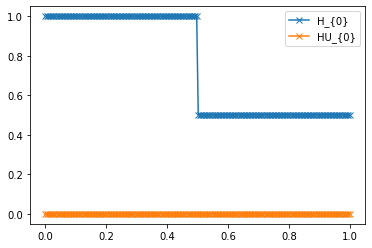

In [136]:
#Konečné objemy
N = 200;
dx = 1/(N-1)
dt = 0.001;
xo = 0;
net = np.arange(xo,xo+(N)*dx,dx)
grav = 9.81
#pocáteční podmínka:
ql = 1
qr =.5
#init Q_{0}
H = np.zeros([1,N])
HU = np.zeros([1,N])
H[0,0:int(N/2)] = ql
H[0,int(N/2):N] = qr
Q = np.concatenate((H, HU))
# problem_data
problem_data = {'grav' : grav,
               'efix' : False}
aux_l, aux_r = 0, 0
#počáteční hloubka, počáteční rychlost
plt.plot(net,Q[0,:],marker="x",label="H_{0}")
plt.plot(net,Q[1,:],marker="x",label="HU_{0}")
plt.legend()
plt.show()

__Godunova metoda__
$$ Q_{i}^{n+1}=Q_{i}^{n}-\frac{\Delta t}{\Delta x}(A^{+}\Delta Q_{i-\frac{1}{2}}-A^{-}\Delta Q_{i+\frac{1}{2}}) $$

<ipython-input-109-7ef1c5beb46c>:25: RuntimeWarning: invalid value encountered in sqrt
  ubar = ( (q_l[1,:]/np.sqrt(q_l[0,:]) + q_r[1,:]/np.sqrt(q_r[0,:])) /
<ipython-input-109-7ef1c5beb46c>:26: RuntimeWarning: invalid value encountered in sqrt
  (np.sqrt(q_l[0,:]) + np.sqrt(q_r[0,:])) )
<ipython-input-109-7ef1c5beb46c>:29: RuntimeWarning: invalid value encountered in sqrt
  c_r = np.sqrt(problem_data['grav'] * q_r[0,:])
<ipython-input-109-7ef1c5beb46c>:31: RuntimeWarning: invalid value encountered in sqrt
  c_l = np.sqrt(problem_data['grav'] * q_l[0,:])


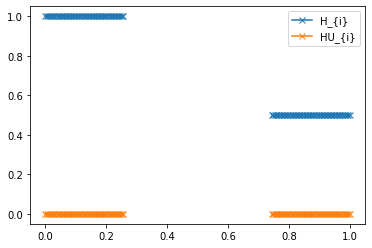

In [134]:
#Godunova metoda
for i in range(50):
    q_l = Q[:,:-1]
    q_r = Q[:,1:]

    #wave, s, amdq, apdq = shallow_roe_1D(q_l, q_r, aux_l, aux_r, problem_data)
    wave, s, amdq, apdq = shallow_hll_1D(q_l, q_r, aux_l, aux_r, problem_data)
    
    Q[:,:-1] = Q[:,:-1] - dt/dx * apdq
    Q[:,1:] = Q[:,1:] - dt/dx * amdq
    
#počáteční hloubka, počáteční rychlost
plt.plot(net,Q[0,:],marker="x",label="H_{i}")
plt.plot(net,Q[1,:],marker="x",label="HU_{i}")
plt.legend()
plt.show()


__Godunova metoda - High-Resolution__
$$ Q_{i}^{n+1}=Q_{i}^{n}-\frac{\Delta t}{\Delta x}(A^{+}\Delta Q_{i-\frac{1}{2}}-A^{-}\Delta Q_{i+\frac{1}{2}})-\frac{\Delta t}{\Delta x}(\tilde{F}_{i+\frac{1}{2}}-\tilde{F}_{i-\frac{1}{2}}), $$
kde
$$\tilde{F}_{i-\frac{1}{2}} = \frac{1}{2}|s_{i-\frac{1}{2}}|(1-\frac{\Delta t}{\Delta x}|s_{i-\frac{1}{2}}|)\tilde{W}_{i-\frac{1}{2}} $$

<ipython-input-109-7ef1c5beb46c>:25: RuntimeWarning: invalid value encountered in sqrt
  ubar = ( (q_l[1,:]/np.sqrt(q_l[0,:]) + q_r[1,:]/np.sqrt(q_r[0,:])) /
<ipython-input-109-7ef1c5beb46c>:26: RuntimeWarning: invalid value encountered in sqrt
  (np.sqrt(q_l[0,:]) + np.sqrt(q_r[0,:])) )
<ipython-input-109-7ef1c5beb46c>:29: RuntimeWarning: invalid value encountered in sqrt
  c_r = np.sqrt(problem_data['grav'] * q_r[0,:])
<ipython-input-109-7ef1c5beb46c>:31: RuntimeWarning: invalid value encountered in sqrt
  c_l = np.sqrt(problem_data['grav'] * q_l[0,:])


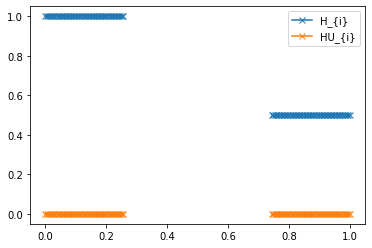

In [138]:
#init Q_{0}
H = np.zeros([1,N])
HU = np.zeros([1,N])
H[0,0:int(N/2)] = ql
H[0,int(N/2):N] = qr
Q = np.concatenate((H, HU))

# Godunova metoda - High-Resolution
for i in range(50):
    q_l = Q[:,:-1]
    q_r = Q[:,1:]

    #wave, s, amdq, apdq = shallow_roe_1D(q_l, q_r, aux_l, aux_r, problem_data)
    wave, s, amdq, apdq = shallow_hll_1D(q_l, q_r, aux_l, aux_r, problem_data)
    
    Q[:,:-1] = Q[:,:-1] - dt/dx * apdq
    Q[:,1:] = Q[:,1:] - dt/dx * amdq
    
#počáteční hloubka, počáteční rychlost
plt.plot(net,Q[0,:],marker="x",label="H_{i}")
plt.plot(net,Q[1,:],marker="x",label="HU_{i}")
plt.legend()
plt.show()

In [27]:
# Roe z Clawpacku
num_eqn = 2
num_waves = 2

def shallow_roe_1D(q_l, q_r, aux_l, aux_r, problem_data):
    r"""
    Roe shallow water solver in 1d::
        ubar = (sqrt(u_l) + sqrt(u_r)) / (sqrt(h_l) + sqrt(h_r))
        cbar = sqrt( 0.5 * g * (h_l + h_r))
        W_1 = |      1      |  s_1 = ubar - cbar
              | ubar - cbar |
        W_2 = |      1      |  s_1 = ubar + cbar
              | ubar + cbar |
        a1 = 0.5 * ( - delta_hu + (ubar + cbar) * delta_h ) / cbar
        a2 = 0.5 * (   delta_hu - (ubar - cbar) * delta_h ) / cbar
    *problem_data* should contain:
     - *g* - (float) Gravitational constant
     - *efix* - (bool) Boolean as to whether a entropy fix should be used, if
       not present, false is assumed
    :Version: 1.0 (2009-02-05)
    """

    # Array shapes
    num_rp = q_l.shape[1]

    # Output arrays
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.zeros( (num_waves, num_rp) )
    amdq = np.zeros( (num_eqn, num_rp) )
    apdq = np.zeros( (num_eqn, num_rp) )

    # Compute roe-averaged quantities
    ubar = ( (q_l[1,:]/np.sqrt(q_l[0,:]) + q_r[1,:]/np.sqrt(q_r[0,:])) /
             (np.sqrt(q_l[0,:]) + np.sqrt(q_r[0,:])) )
    cbar = np.sqrt(0.5 * problem_data['grav'] * (q_l[0,:] + q_r[0,:]))

    # Compute Flux structure
    delta = q_r - q_l
    a1 = 0.5 * (-delta[1,:] + (ubar + cbar) * delta[0,:]) / cbar
    a2 = 0.5 * ( delta[1,:] - (ubar - cbar) * delta[0,:]) / cbar

    # Compute each family of waves
    wave[0,0,:] = a1
    wave[1,0,:] = a1 * (ubar - cbar)
    s[0,:] = ubar - cbar

    wave[0,1,:] = a2
    wave[1,1,:] = a2 * (ubar + cbar)
    s[1,:] = ubar + cbar

    if problem_data['efix']:
        raise NotImplementedError("Entropy fix has not been implemented.")
    else:
        s_index = np.zeros((2,num_rp))
        for m in range(num_eqn):
            for mw in range(num_waves):
                s_index[0,:] = s[mw,:]
                amdq[m,:] += np.min(s_index,axis=0) * wave[m,mw,:]
                apdq[m,:] += np.max(s_index,axis=0) * wave[m,mw,:]

    return wave, s, amdq, apdq

In [109]:
# HLL z Clawpacku

def shallow_hll_1D(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    HLL shallow water solver ::
        W_1 = Q_hat - Q_l    s_1 = min(u_l-c_l,u_l+c_l,lambda_roe_1,lambda_roe_2)
        W_2 = Q_r - Q_hat    s_2 = max(u_r-c_r,u_r+c_r,lambda_roe_1,lambda_roe_2)
        Q_hat = ( f(q_r) - f(q_l) - s_2 * q_r + s_1 * q_l ) / (s_1 - s_2)
    *problem_data* should contain:
     - *g* - (float) Gravitational constant
    :Version: 1.0 (2009-02-05)
    """
    # Array shapes
    num_rp = q_l.shape[1]
    num_eqn = 2
    num_waves = 2

    # Output arrays
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.zeros( (num_eqn, num_rp) )
    apdq = np.zeros( (num_eqn, num_rp) )

    # Compute Roe and right and left speeds
    ubar = ( (q_l[1,:]/np.sqrt(q_l[0,:]) + q_r[1,:]/np.sqrt(q_r[0,:])) /
        (np.sqrt(q_l[0,:]) + np.sqrt(q_r[0,:])) )
    cbar = np.sqrt(0.5 * problem_data['grav'] * (q_l[0,:] + q_r[0,:]))
    u_r = q_r[1,:] / q_r[0,:]
    c_r = np.sqrt(problem_data['grav'] * q_r[0,:])
    u_l = q_l[1,:] / q_l[0,:]
    c_l = np.sqrt(problem_data['grav'] * q_l[0,:])

    # Compute Einfeldt speeds
    s_index = np.empty((4,num_rp))
    s_index[0,:] = ubar+cbar
    s_index[1,:] = ubar-cbar
    s_index[2,:] = u_l + c_l
    s_index[3,:] = u_l - c_l
    s[0,:] = np.min(s_index,axis=0)
    s_index[2,:] = u_r + c_r
    s_index[3,:] = u_r - c_r
    s[1,:] = np.max(s_index,axis=0)

    # Compute middle state
    q_hat = np.empty((2,num_rp))
    q_hat[0,:] = ((q_r[1,:] - q_l[1,:] - s[1,:] * q_r[0,:]
                            + s[0,:] * q_l[0,:]) / (s[0,:] - s[1,:]))
    q_hat[1,:] = ((q_r[1,:]**2/q_r[0,:] + 0.5 * problem_data['grav'] * q_r[0,:]**2
                - (q_l[1,:]**2/q_l[0,:] + 0.5 * problem_data['grav'] * q_l[0,:]**2)
                - s[1,:] * q_r[1,:] + s[0,:] * q_l[1,:]) / (s[0,:] - s[1,:]))

    # Compute each family of waves
    wave[:,0,:] = q_hat - q_l
    wave[:,1,:] = q_r - q_hat

    # Compute variations
    s_index = np.zeros((2,num_rp))
    for m in range(num_eqn):
        for mw in range(num_waves):
            s_index[0,:] = s[mw,:]
            amdq[m,:] += np.min(s_index,axis=0) * wave[m,mw,:]
            apdq[m,:] += np.max(s_index,axis=0) * wave[m,mw,:]

    return wave, s, amdq, apdq
